In [1]:
"""
Install virtual enviroment outside project folder.
In command line enter:
python3 -m venv multimodal
python3 -m ipykernel install --user --name=multimodal
Start `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks
Select `multimodal` kernel in right upper corner.
!pip install -r ../requirements.txt

"""

'\nInstall virtual enviroment outside project folder.\nIn command line enter:\npython3 -m venv multimodal\npython3 -m ipykernel install --user --name=multimodal\nStart `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks\nSelect `multimodal` kernel in right upper corner.\n!pip install -r ../requirements.txt\n\n'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import time
import whisper
import numpy
import warnings

# Inside the /Multimodal-Deep-Regression/notebooks
import sys

sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import (
    get_base_tensor_directories,
    generate_batch,
    process_data,
    add_ae_tensor,
    get_ensemble_data,
    generate_batch_ensemble,
    generate_autoencoder_batch,
)
from util.audio_utilities import extract_embeddings, extract_audio

In [2]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = "cpu"  # get_device() # CPU or GPU
DATASET = "video_pack_1000"
FRAME_SKIP = 100  # how many frame to skip, reduce depth
SHRINK = 8  # shrink the scale (H x W)//N
NORMALIZE = False  # normalize the pixel to 0 to 1
PAD_ALL = False  # pad all tensors with max depth
BATCH_SIZE = 2

In [3]:
# ConvLSTMAutoencoder Hyper-Parameters
LEARNING_RATE = 1e-4
EPOCHS = 80
HIDDEN_SIZE = 64  # ConvLSTMAutoencoder hidden size

In [4]:
# Transformer Visual & Audio Hyper-Parameters
NUM_HEADS = 8  # number of attenion heads
HIDDEN_DIM = 256  # Transformer hidden size
NUM_LAYERS = 6  # number of Transformer layers

# EnsembleModel Hyper-Parameters
LEARNING = 1e-3
THE_EPOCHS = 80
AUDIO_TRANSFORMER = True  # if False, will skip audio transfomer part #NOT WORKING YET
LATE_FUSION = True  # early fusion or late fusion #NOT WORKING YET

In [6]:
# extract audio from video dataset
extract_audio(f"../data/video_packs/{DATASET}/", f"../data/audio/{DATASET}")

# using whipser to transcribe audio dialog & extract LLMs embedding
extract_embeddings(
    audio_file_path=f"../data/audio/{DATASET}",
    output_dir="../data/audio_embeddings/",
    device=get_device(),
    windows_os=True,
)

Extract in audio from video pack to .wav format..


100%|██████████| 1000/1000 [00:00<00:00, 111086.79it/s]

You are using device: cuda


Converting to audio files to embeddings..


100%|██████████| 1000/1000 [00:06<00:00, 143.60it/s]

Error extracting embeddings for 7248132092326956290.
local variable 'encoder_embeddings' referenced before assignment


In [7]:
# disable pyav warning
warnings.filterwarnings(
    "ignore", message="Accurate seek is not implemented for pyav backend"
)

# video visual processing
process_data(
    input_type=DATASET,
    # addition_parameters={'first_n_videos': 10},
    verbose=False,
    device=get_device(),
    frames_to_skip=FRAME_SKIP,
    shrink=SHRINK,
    normalize=NORMALIZE,
)

You are using device: cuda
Processing video visual to tensors..


100%|██████████| 1000/1000 [00:00<00:00, 11763.15it/s]


In [5]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

In [6]:
# load all visual tensors
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

# split the data
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=False
)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [7]:
# Create AutoEncoder Batches with DataLoaders
batch_size = BATCH_SIZE
train_loader = list(zip(x_train, x_train))
val_loader = list(zip(x_val, x_val))
train_loader = DataLoader(
    train_loader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=generate_autoencoder_batch,
)
val_loader = DataLoader(
    val_loader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=generate_autoencoder_batch,
)

# check size Batch, Channel, Frame, Height, Width
data, targets = next(iter(train_loader))
data.size(), targets.size()

(torch.Size([2, 3, 2, 128, 72]), torch.Size([2, 3, 2, 128, 72]))

In [10]:
from models import ConvLSTMAutoencoder

autoencoder = ConvLSTMAutoencoder(
    hidden_dim=HIDDEN_SIZE, shrink=SHRINK, normalize=NORMALIZE
)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 1,041,859


In [8]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = "ConvLSTMAutoencoder_hidden6222_weights.pt"  # save the weights
autoencoder_load = False

In [11]:
# load check point
weights_file = f"../models/save/{SAVE_NAME}"
autoencoder.load_state_dict(torch.load(weights_file)["model_state_dict"])
autoencoder_load = True
train_losses = torch.load(weights_file)["train_losses"]
val_losses = torch.load(weights_file)["val_losses"]

In [13]:
start_time = time.time()

if not autoencoder_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(
        autoencoder, train_loader, criterion, optimizer, DEVICE
    )
    val_loss, avg_val_loss = evaluate(autoencoder, val_loader, criterion, DEVICE)

    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    echo = ECHO
    if ((epoch + 1) % echo == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f"First epoch took {time_took:.1f} minutes.")
        print(
            f"Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}"
        )

First epoch took 34.1 minutes.
Epoch 1/80, Train_Loss: 1698194.83, Avg: 4245.49; Val_Loss: 357378.28, Avg: 3573.78
Epoch 2/80, Train_Loss: 1316133.69, Avg: 3290.33; Val_Loss: 352659.50, Avg: 3526.59
Epoch 3/80, Train_Loss: 1140611.07, Avg: 2851.53; Val_Loss: 290835.79, Avg: 2908.36
Epoch 4/80, Train_Loss: 1041027.86, Avg: 2602.57; Val_Loss: 274199.89, Avg: 2742.00
Epoch 5/80, Train_Loss: 969056.89, Avg: 2422.64; Val_Loss: 254089.06, Avg: 2540.89
Epoch 6/80, Train_Loss: 851745.96, Avg: 2129.36; Val_Loss: 233839.10, Avg: 2338.39
Epoch 7/80, Train_Loss: 777076.47, Avg: 1942.69; Val_Loss: 222559.39, Avg: 2225.59
Epoch 8/80, Train_Loss: 715158.67, Avg: 1787.90; Val_Loss: 210975.00, Avg: 2109.75
Epoch 9/80, Train_Loss: 691519.99, Avg: 1728.80; Val_Loss: 194625.82, Avg: 1946.26
Epoch 10/80, Train_Loss: 644378.24, Avg: 1610.95; Val_Loss: 191980.83, Avg: 1919.81
Epoch 11/80, Train_Loss: 659515.28, Avg: 1648.79; Val_Loss: 177450.86, Avg: 1774.51
Epoch 12/80, Train_Loss: 597860.07, Avg: 1494.65; 

In [14]:
if not autoencoder_load:
    # save model if better or not exists
    model_weights = {
        "model_state_dict": autoencoder.state_dict(),
        "val_loss": avg_train_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    weights_file = f"../models/save/{SAVE_NAME}"
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print("save new model")
    elif model_weights["val_loss"] < torch.load(weights_file)["val_loss"]:
        # replace
        torch.save(model_weights, weights_file)
        print("replace old model")
    else:
        print("old model perform better")

replace old model


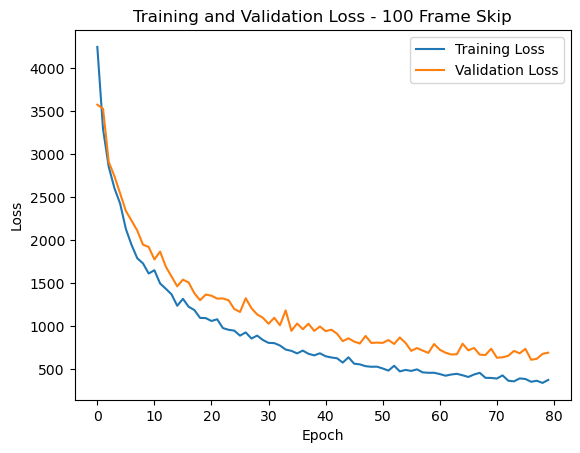

In [18]:
# loss plot
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - 100 Frame Skip")
plt.legend()
plt.show()

Actual:
torch.Size([3, 128, 72])


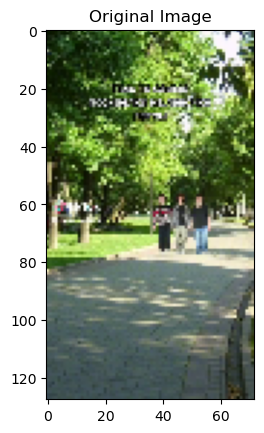

torch.Size([3, 128, 72])


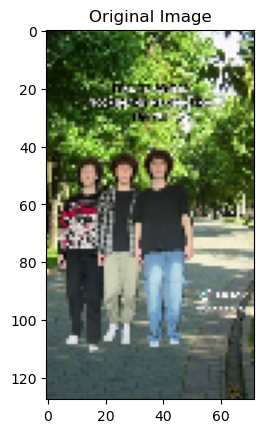

torch.Size([3, 128, 72])


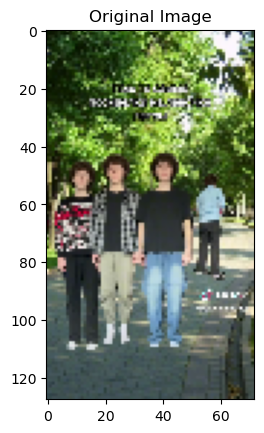

AutoEncoder:


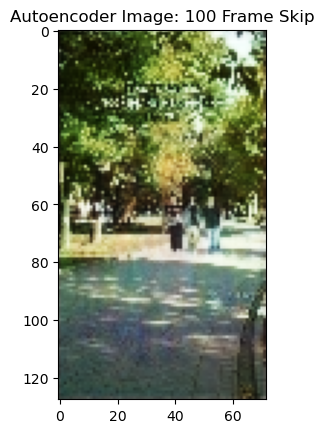

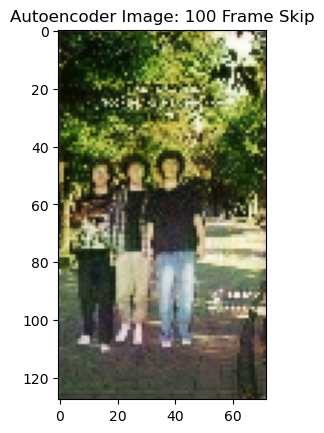

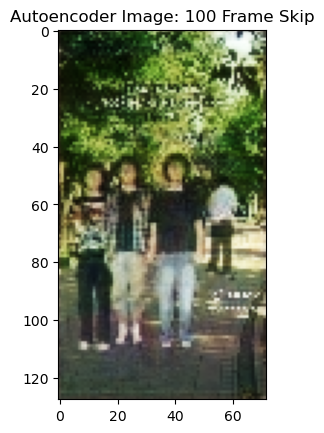

In [17]:
# Random sample inspection
# random_num = random.randint(0, len(val_loader)-1)
random_num = 50

for i, (inputs, targets) in enumerate(val_loader):
    if i == random_num:  # random sample
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        outputs = autoencoder(inputs).detach()
        break


# Actual
print("Actual:")
for i in range(3):
    # select first 3 frame
    image_tensor = targets.squeeze()[0, :, i, :, :]
    print(image_tensor.size())
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (
        numpy_image.max() - numpy_image.min()
    )

    plt.imshow(numpy_image)
    plt.title("Original Image")
    plt.show()

# AutoEncoder
print("AutoEncoder:")
for i in range(3):
    # select first 3 frame
    image_tensor = outputs.squeeze()[0, :, i, :, :]
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (
        numpy_image.max() - numpy_image.min()
    )

    plt.imshow(numpy_image)
    plt.title("Autoencoder Image: 100 Frame Skip")
    plt.show()

In [17]:
# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=False
)

train_loader = list(zip(x_train, y_train))
val_loader = list(zip(x_val, y_val))
train_loader = DataLoader(
    train_loader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=generate_batch_ensemble,
)
val_loader = DataLoader(
    val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble
)

print(f"Train set size: {len(x_train)}")
print(f"Val set size: {len(x_val)}")

Train set size: 800
Val set size: 200


In [19]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModel

model1 = TransformerModel_Visual(
    d_model=9216, nhead=NUM_HEADS, d_hid=HIDDEN_DIM, nlayers=NUM_LAYERS
)

model2 = TransformerModel_Audio(
    d_model=512, nhead=NUM_HEADS, d_hid=HIDDEN_DIM, nlayers=NUM_LAYERS
)

ensemble_model = EnsembleModel(model1, model2)
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 2,227,312,129


In [20]:
# Training
def ensemble_train(
    ensemble_model,
    autoencoder,
    dataloader,
    criterion,
    optimizer,
    device="cpu",
    verbose=False,
):
    ensemble_model.train()
    total_loss = 0.0
    for visuals, audio_embeds, targets in dataloader:
        visuals, audio_embeds, targets = (
            visuals.to(device),
            audio_embeds.to(device),
            targets.to(device),
        )
        visual_embeds = autoencoder.getembedding(visuals).detach()
        outputs = ensemble_model.forward(visual_embeds, audio_embeds)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss


# Evaluate
def ensemble_evaluate(
    ensemble_model, autoencoder, dataloader, criterion, device="cpu", verbose=False
):
    ensemble_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for visuals, audio_embeds, targets in dataloader:
            visuals, audio_embeds, targets = (
                visuals.to(device),
                audio_embeds.to(device),
                targets.to(device),
            )
            visual_embeds = autoencoder.getembedding(visuals).detach()
            outputs = ensemble_model.forward(visual_embeds, audio_embeds)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        return total_loss, avg_loss

In [21]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = "EnsembleModel_hidden51222_weights_long_running.pt"  # save the weights
ensemble_model_load = False

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=LEARNING)

# EPOCHS = THE_EPOCHS
EPOCHS = 20
start_time = time.time()

if not ensemble_model_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = ensemble_train(
        ensemble_model, autoencoder, train_loader, criterion, optimizer, DEVICE
    )
    val_loss, avg_val_loss = ensemble_evaluate(
        ensemble_model, autoencoder, val_loader, criterion, DEVICE
    )

    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = ECHO
    if ((epoch + 1) % ECHO == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f"First epoch took {time_took:.1f} minutes.")
        print(
            f"Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}"
        )

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1019215872 bytes.

In [ ]:
if not ensemble_model_load:
    # save model if better or not exists
    model_weights = {
        "model_state_dict": ensemble_model.state_dict(),
        "val_loss": avg_train_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    weights_file = f"../models/save/{SAVE_NAME}"
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print("save new model")
    elif model_weights["val_loss"] < torch.load(weights_file)["val_loss"]:
        # replace
        torch.save(model_weights, weights_file)
        print("replace old model")
    else:
        print("old model perform better")

replace old model


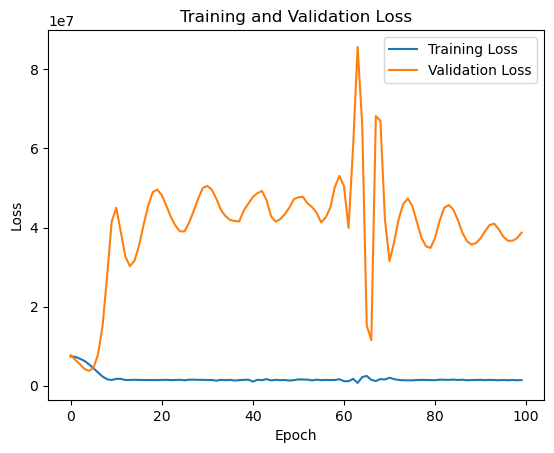

In [ ]:
# loss plot
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

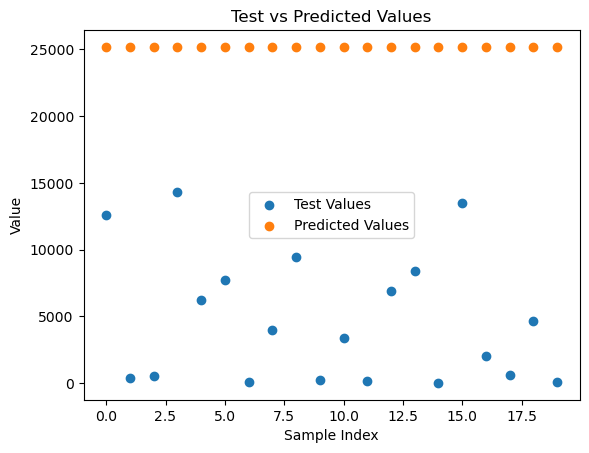

In [ ]:
# compare to validation set
val_values = []
predicted_values = []

for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = (
        visuals.to(DEVICE),
        audio_embeds.to(DEVICE),
        targets.to(DEVICE),
    )
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())

plt.scatter(range(len(val_values)), val_values, label="Test Values")
plt.scatter(range(len(predicted_values)), predicted_values, label="Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Test vs Predicted Values")
plt.legend()
plt.show()

In [ ]:
# Inspect first N
N = 10
val_check = [round(i, 2) for i in val_values][:N]
predicted_check = [round(i, 2) for i in predicted_values][:N]
print("Val", val_check)
print("Predict", predicted_check)

Val [12600.0, 364.6, 511.1, 14300.0, 6200.0, 7700.0, 56.8, 3958.0, 9420.0, 184.6]
Predict [25184.06, 25184.07, 25184.07, 25184.05, 25184.04, 25184.07, 25184.03, 25184.0, 25184.05, 25184.04]


In [ ]:
# get MSE for the vaildation set
mse = mean_squared_error(val_values, predicted_values)
print(f"MSE: {mse:.2f}, Lenght: {len(val_values)}")

MSE: 440358897.06, Lenght: 20
